In [1]:
from google.colab import files
uploaded = files.upload()#reading the data



Saving processed_reviews.csv to processed_reviews.csv


In [2]:
import pandas as pd
df1 = pd.read_csv('processed_reviews.csv')
df1

,review_lemmatized,label
0,"['not', 'bad', 'stay', 'pretty', 'pleasant', '...",positive
1,"['westin', 'time', 'square', 'cheat', 'custome...",negative
2,"['good', 'news', 'bad', 'news', 'seattle', 'ni...",positive
3,"['expectation', 'book', 'riu', 'bambu', 'onlin...",negative
4,"['hospital', 'stay', 'week', 'get', 'sick', 's...",negative
...,...,...
17835,"['great', 'location', 'pay', 'stay', 'palace',...",negative
17836,"['simply', 'awful', 'hotel', 'bad', 'state', '...",negative
17837,"['second', 'time', 'stay', 'daughter', 'husban...",positive
17838,"[""n't"", 'worry', 'old', 'review', 'return', 's...",positive


In [3]:
import ast

# تحويل العمود من string إلى list
df1['review_lemmatized'] = df1['review_lemmatized'].apply(ast.literal_eval)


In [4]:
# implementing CO-Occurrence feature extractor(using sparse matrix)
from collections import defaultdict, Counter
from scipy.sparse import lil_matrix


window_size = 2

co_occurrences = defaultdict(Counter)

for tokens in df1['review_lemmatized']:
    for i, word in enumerate(tokens):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                co_occurrences[word][tokens[j]] += 1

unique_words = list(set(word for tokens in df1['review_lemmatized'] for word in tokens))
word_index = {word: idx for idx, word in enumerate(unique_words)}

co_matrix = lil_matrix((len(df1), len(unique_words)), dtype=int)

for doc_idx, tokens in enumerate(df1['review_lemmatized']):
    for i, word in enumerate(tokens):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:
                if word in word_index and tokens[j] in word_index:
                    co_matrix[doc_idx, word_index[tokens[j]]] += 1

co_matrix_df = pd.DataFrame(co_matrix.toarray(), index=df1.index, columns=unique_words)

print(co_matrix_df.iloc[:10, :10])


   stephenkim  belltownits  resortwhich  katrinafrom  ropey  modestly  login  \
0           0            0            0            0      0         0      0   
1           0            0            0            0      0         0      0   
2           0            0            0            0      0         0      0   
3           0            0            0            0      0         0      0   
4           0            0            0            0      0         0      0   
5           0            0            0            0      0         0      0   
6           0            0            0            0      0         0      0   
7           0            0            0            0      0         0      0   
8           0            0            0            0      0         0      0   
9           0            0            0            0      0         0      0   

   yearsi  slipperybreakfast  theatres  
0       0                  0         0  
1       0                  0         

In [5]:
# split training set and test set
X = co_matrix_df
y = df1['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# implement logisitic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

c_values = [0.001, 0.01, 0.1, 1, 10, 100]

results = []

for c in c_values:
    model = LogisticRegression(C=c, penalty='l2', max_iter=1000, solver='lbfgs', random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    gap = train_acc - test_acc

    results.append({
        'C': c,
        'Train Accuracy': round(train_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2),
        'Gap': round(gap * 100, 2)
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Test Accuracy', ascending=False))



         C  Train Accuracy  Test Accuracy    Gap
3    1.000           99.99          87.81  12.18
2    0.100           99.43          87.67  11.76
1    0.010           95.19          87.19   8.00
4   10.000          100.00          86.97  13.03
5  100.000          100.00          86.72  13.28
0    0.001           88.84          85.85   2.99


In [ ]:
optimal_c = 0.001

model_optimal = LogisticRegression(C=optimal_c, penalty='l2', max_iter=1000, solver='lbfgs', random_state=42)
model_optimal.fit(X_train, y_train)


LogisticRegression(C=0.001, max_iter=1000, random_state=42)

In [ ]:
# Training accuracy
train_accuracy = model_optimal.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


Training Accuracy: 88.84%


In [ ]:
#test accuracy
test_accuracy = model_optimal.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 85.85%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_train_pred = model_optimal.predict(X_train)
y_test_pred = model_optimal.predict(X_test)

y_test_numeric = y_test.map({'negative': 0, 'positive': 1})
y_test_pred_numeric = pd.Series(y_test_pred).map({'negative': 0, 'positive': 1})

precision = precision_score(y_test_numeric, y_test_pred_numeric)
recall = recall_score(y_test_numeric, y_test_pred_numeric)
f1 = f1_score(y_test_numeric, y_test_pred_numeric)

y_test_proba = model_optimal.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test_numeric, y_test_proba)


print("Model Evaluation on Test Set:")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"AUC Score: {auc:.2f}")


Model Evaluation on Test Set:
Precision: 0.84
Recall:    0.89
F1 Score:  0.86
AUC Score: 0.91


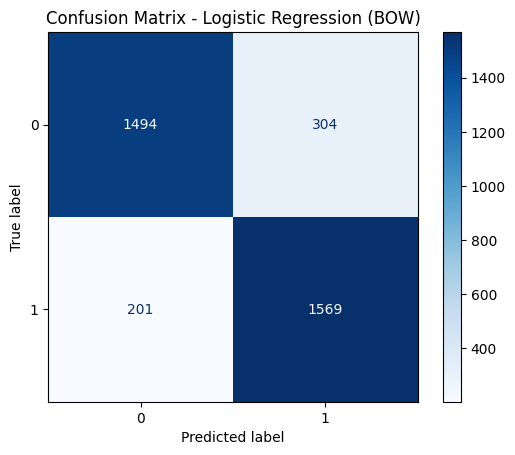

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = model_optimal.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (BOW)")
plt.show()

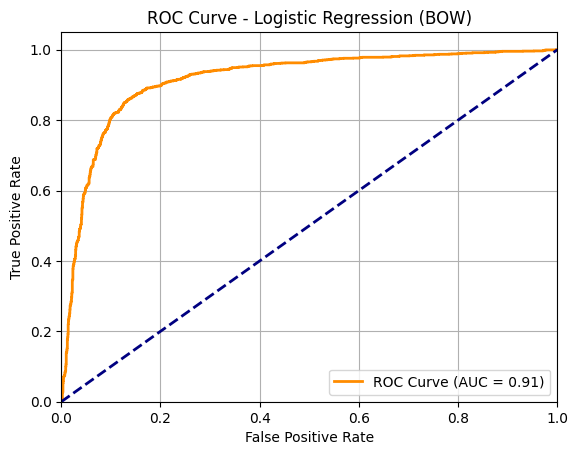

In [ ]:
#ROC CURVE

from sklearn.metrics import roc_curve, auc

y_test_numeric = y_test.map({'negative': 0, 'positive': 1})

y_prob =model_optimal.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_numeric, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (BOW)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [6]:
!pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 35.8 MB/s eta 0:00:00


In [7]:
!pip install --upgrade lightgbm


In [20]:
#Implement gradient boosting model
import lightgbm as lgb

lgb_model= lgb.LGBMClassifier(
    n_estimators=500,
    max_depth=6,
    num_leaves=12,
    learning_rate=0.05,
    min_data_in_leaf=90,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=2,
    random_state=42
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 7150, number of nega

LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, feature_fraction=0.9,
               learning_rate=0.05, max_depth=6, min_data_in_leaf=90,
               n_estimators=500, num_leaves=12, random_state=42)

In [21]:
# Training accuracy
train_accuracy2 = lgb_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy2 * 100:.2f}%")

#test accuracy
test_accuracy2 = lgb_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy2 * 100:.2f}%")

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Training Accuracy: 89.86%
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
Test Accuracy: 85.09%


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score

y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

y_test_numeric = y_test.map({'negative': 0, 'positive': 1})
y_test_pred_numeric = pd.Series(y_test_pred).map({'negative': 0, 'positive': 1})

precision = precision_score(y_test_numeric, y_test_pred_numeric)
recall = recall_score(y_test_numeric, y_test_pred_numeric)
f1 = f1_score(y_test_numeric, y_test_pred_numeric)

y_test_proba = lgb_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test_numeric, y_test_proba)


print("Model Evaluation on Test Set:")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"AUC Score: {auc:.2f}")


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


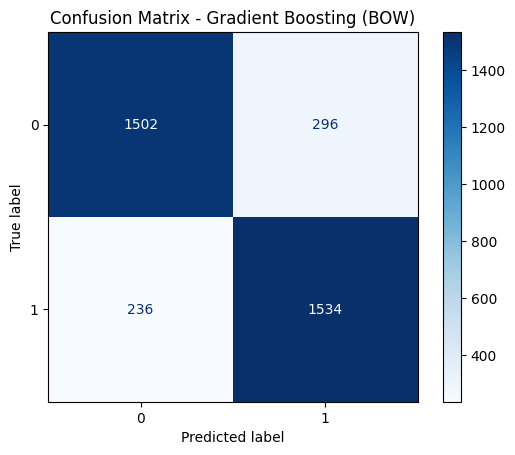

In [25]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = lgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting (BOW)")
plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


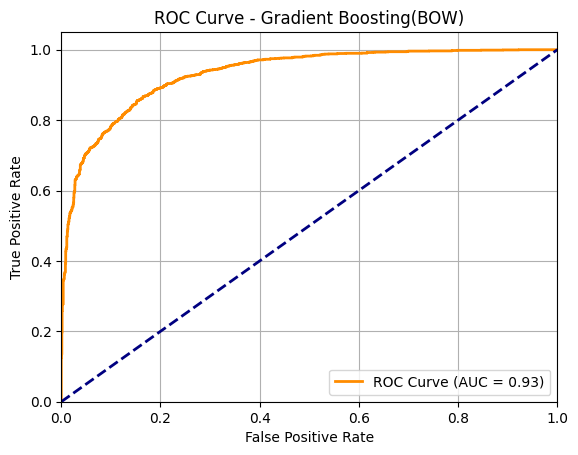

In [26]:
#ROC CURVE

from sklearn.metrics import roc_curve, auc

y_test_numeric = y_test.map({'negative': 0, 'positive': 1})

y_prob = lgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_numeric, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting(BOW)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [27]:
#implement naive.bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import pandas as pd

results = []

for alpha in [0.01, 0.1, 1.0, 5.0, 10.0]:
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train, y_train)

    y_train_pred = nb.predict(X_train)
    y_test_pred = nb.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    gap = train_acc - test_acc  # overfitting indicator

    results.append({
        'Alpha': alpha,
        'Train Accuracy': round(train_acc * 100, 2),
        'Test Accuracy': round(test_acc * 100, 2),
        'Gap': round(gap * 100, 2)
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Test Accuracy', ascending=False))


   Alpha  Train Accuracy  Test Accuracy    Gap
3   5.00           90.72          85.43   5.29
1   0.10           95.15          84.87  10.29
2   1.00           93.15          84.84   8.31
0   0.01           95.89          84.61  11.28
4  10.00           88.96          84.59   4.37


In [28]:
best_alpha = 5.0

nb_best = MultinomialNB(alpha=best_alpha)
nb_best.fit(X_train, y_train)


MultinomialNB(alpha=5.0)

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_train_pred = nb_best.predict(X_train)
y_test_pred = nb_best.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

y_test_numeric = y_test.map({'negative': 0, 'positive': 1})
y_test_pred_numeric = pd.Series(y_test_pred).map({'negative': 0, 'positive': 1})

precision = precision_score(y_test_numeric, y_test_pred_numeric)
recall = recall_score(y_test_numeric, y_test_pred_numeric)
f1 = f1_score(y_test_numeric, y_test_pred_numeric)

y_test_proba = nb_best.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test_numeric, y_test_proba)


print("Model Evaluation on Test Set:")
print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy:     {test_acc * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"AUC Score: {auc:.2f}")


Model Evaluation on Test Set:

Training Accuracy: 90.72%
Test Accuracy:     85.43%
Precision: 0.84
Recall:    0.87
F1 Score:  0.86
AUC Score: 0.91


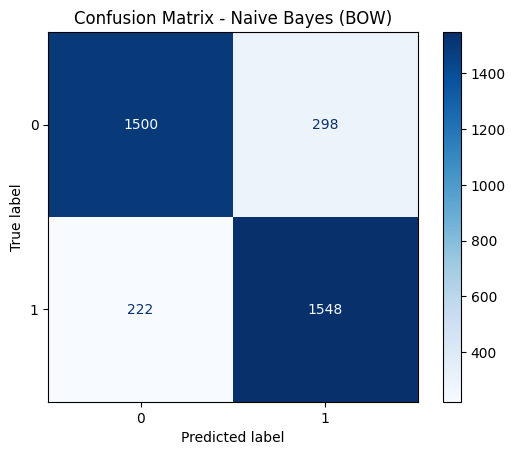

In [30]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred = nb_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (BOW)")
plt.show()

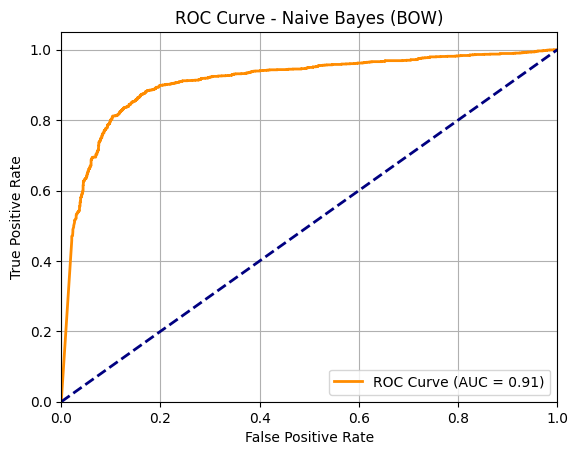

In [31]:
#ROC CURVE

from sklearn.metrics import roc_curve, auc

y_test_numeric = y_test.map({'negative': 0, 'positive': 1})

y_prob = nb_best.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_numeric, y_prob)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes (BOW)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [ ]:
!pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
#implement Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np


X_dense = co_matrix_df.values.astype('float32')
y_array = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_dense, y_array, test_size=0.2, random_state=42)

#build model with regularitization
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# train model using adam optimizer
model.compile(optimizer=Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.8088 - loss: 1.1892 - val_accuracy: 0.8487 - val_loss: 0.7712
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 80s 224ms/step - accuracy: 0.8533 - loss: 0.7508 - val_accuracy: 0.8420 - val_loss: 0.7743
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.8579 - loss: 0.7234 - val_accuracy: 0.8469 - val_loss: 0.7397
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 78s 219ms/step - accuracy: 0.8630 - loss: 0.7102 - val_accuracy: 0.8574 - val_loss: 0.7523
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - accuracy: 0.8714 - loss: 0.7003 - val_accuracy: 0.8578 - val_loss: 0.7532
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 79s 220ms/step - accuracy: 0.8673 - loss: 0.6843 - val_accuracy: 0.8574 - val_loss: 0.7252
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.8662 - loss: 0.6835 - val_accuracy: 0.8578 - val_loss: 0.7047
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - accuracy: 0.8713 - loss: 0

In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Training Accuracy: 89.76%
Test Accuracy: 86.32%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. توقعات النموذج (على بيانات الاختبار)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# 2. حساب المقاييس
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# 3. طباعة النتائج
print(f"Accuracy :  {accuracy:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall   :  {recall:.4f}")
print(f"F1-Score :  {f1:.4f}")
print(f"AUC      :  {auc:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Accuracy :  0.8632
Precision:  0.8937
Recall   :  0.8220
F1-Score :  0.8564
AUC      :  0.9439


In [ ]:
#prediction
y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


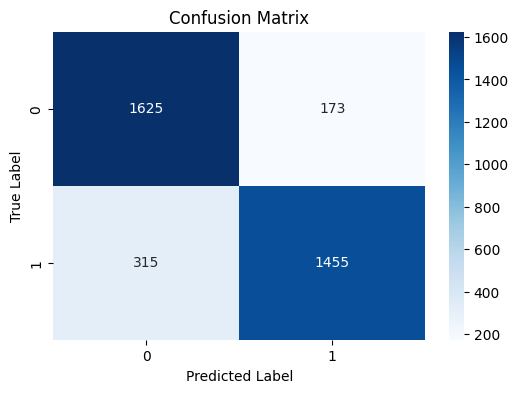

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


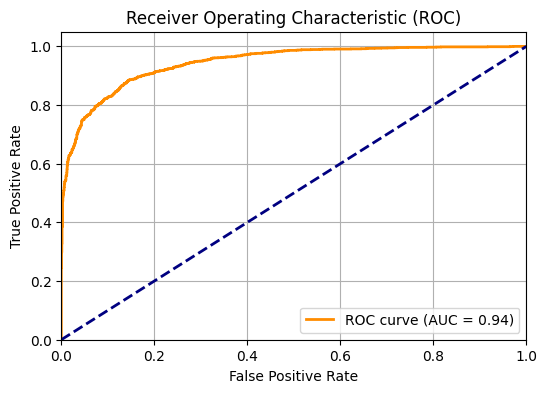

In [ ]:
#ROC CURVE
from sklearn.metrics import roc_curve, auc

# FPR ,TPR ,Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
